In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Primeiro Entregável

O primeiro entregável desse cenário deve ser um relatório relatando algumas das anomalias encontradas e investigações possíveis (falamos que aqui encorajamos gente curiosa, certo?!). Para feitura desse relatório vocês podem utilizar quaisquer ferramentas de modelagem ou visualização de dados (sugerimos começar com um EDA via pandas, visualizações via matplotlib/seaborn etc).

O dataset a ser utilizado nesse cenário (.zip com arquivo CSV) você encontra <a href="https://drive.google.com/file/d/1a8UCbzXFbqTQi0x8tqCXPRTlB--E7o8I/view?usp=sharing">aqui</a>.

Temos um apreço muito grande por trabalhos por análises que levantem as hipóteses mais importantes para nosso processo de pré vendas. Sendo assim, é bom contarmos com métricas para nos previnir e alertar sobre quaisquer problemas bem como monitorar as arquitetura proposta. Logo, apreciamos se você conseguir apontar também possíveis KPIs ou fornecer insights que possam melhorar o acompanhamento do processo da empresa desse primeiro cenário.


## Dados

| Table            | Total Rows | Total Columns                                              |
| -----------------|:--------:  | :---------------------------------------------------------:|
| Orders           | 9994       | 21                                                         |
| People           | 4          | 2                                                          |
| Returns          | 296        | 2                                                          |

In [5]:
## carregando o dataset

data_url = '../data/01_raw/sample.xls'

orders = pd.read_excel(data_url, sheet_name='Orders')
people = pd.read_excel(data_url, sheet_name='People')
returns = pd.read_excel(data_url, sheet_name='Returns')

for dataset in [orders,people,returns]:
    dataset.columns = [c.lower().replace(' ','_') for c in dataset.columns]

display(orders.head(2))
display(people.head(2))
display(returns.head(2))

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,postal_code,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


,person,region
0,Anna Andreadi,West
1,Chuck Magee,East


,returned,order_id
0,Yes,CA-2017-153822
1,Yes,CA-2017-129707


## Validações

1. Todas as vendas gravadas em 'orders' são únicas;
2. Todas as pessoas em gravadas em 'people' tem pelo menos 1 compra gravada em 'orders'.
3. Todas as devoluções em 'return' são únicas;
4. Todas as devoluções gravadas em 'returns' também estão em 'orders', ou seja, não há devoluções sem compra prévia;
5. Os campos 'sales' e 'quantity' da base 'orders' não podem ser negativos;
6. O campo 'ship_date' deve ser maior que 'order_date' na base 'orders'.

### 1. Todas as vendas gravadas em 'orders' são únicas;

In [6]:
(
    orders.
    order_id
    .nunique()
) == orders.shape[0]

False

Dado que a quantidade de linhas da base 'orders' é diferente da quantidade de valores únicos da coluna 'order_id' podemos entender que existe a possibilidade de várias linhas com a mesma 'order_id', caracterizando produtos diferentes em um mesmo pedido. Ou seja, a granularidade da base 'orders' é produto-pedido, ou seja, cada linha representa um produto diferente em um pedido.

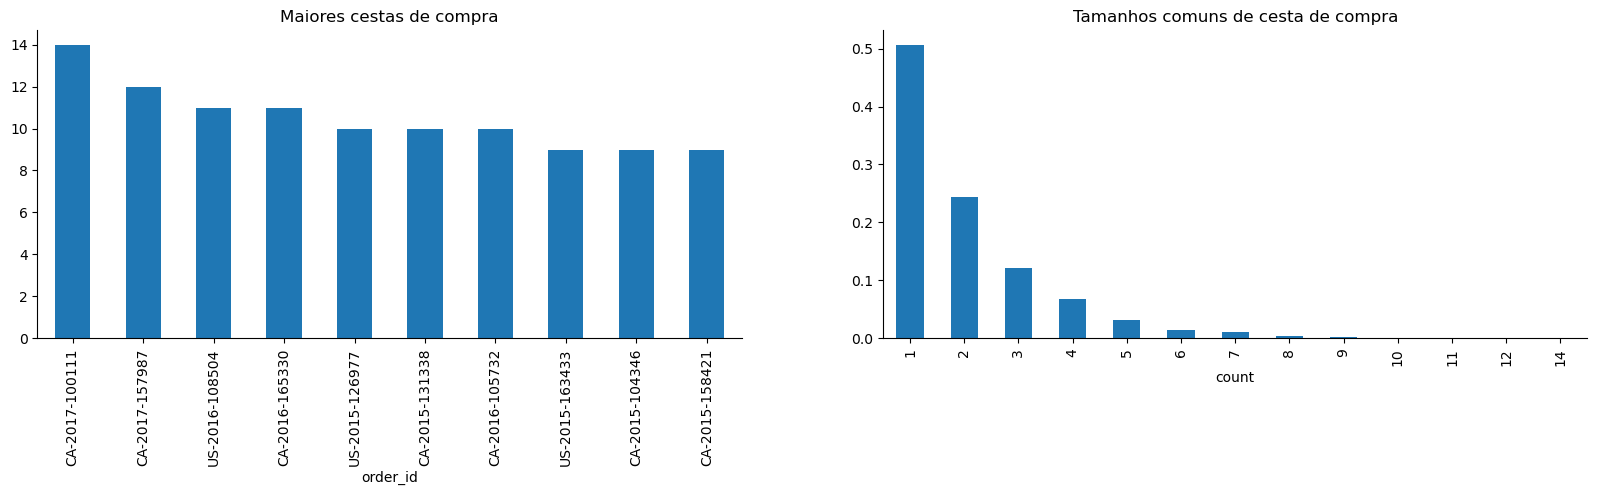

In [7]:
f, ax = plt.subplots(1,2,figsize=(20,4))

(
    orders
    .order_id
    .value_counts()
    .nlargest(10)
    .plot(kind='bar', ax=ax[0])
)

(
    orders
    .order_id
    .value_counts() ## contando quantos produtos diferentes temos em cada pedido
    .value_counts(normalize=True) ## contando os tamanhos comuns da cesta de produtos
    .plot(kind='bar', ax=ax[1])
)


for chart, title in enumerate(['Maiores cestas de compra','Tamanhos comuns de cesta de compra']):
    ax[chart].spines['right'].set_visible(False)
    ax[chart].spines['top'].set_visible(False)
    ax[chart].set_title(title)

In [8]:
## conferindo a diversidade do pedido
display(orders[orders.order_id == 'CA-2017-100111'].product_id.nunique())

14

O pedido mais diverso ('CA-2017-100111') tem 14 produtos diferentes. Porém, compras com somente um item são bem mais comuns. Para respondermos com certeza que cada linha é única agora basta procurar se há linhas totalmente duplicadas.

In [9]:
## conferindo se existem linhas totalmente replicadas
display(orders.duplicated().sum())

## conferindo se existem linhas totalmente replicadas com subset orderId=product_id
display(orders.duplicated(subset=['order_id','product_id'],keep=False).sum())

0

16

In [10]:
orders[orders.duplicated(subset=['order_id','product_id'],keep=False)].iloc[0]

row_id                           351
order_id              CA-2016-129714
order_date       2016-09-01 00:00:00
ship_date        2016-09-03 00:00:00
ship_mode                First Class
customer_id                 AB-10060
customer_name        Adam Bellavance
segment                  Home Office
country                United States
city                   New York City
state                       New York
postal_code                    10009
region                          East
product_id           OFF-PA-10001970
category             Office Supplies
sub-category                   Paper
product_name              Xerox 1881
sales                          24.56
quantity                           2
discount                         0.0
profit                       11.5432
Name: 350, dtype: object

In [11]:
orders[orders.duplicated(subset=['order_id','product_id'],keep=False)].iloc[1]

row_id                           353
order_id              CA-2016-129714
order_date       2016-09-01 00:00:00
ship_date        2016-09-03 00:00:00
ship_mode                First Class
customer_id                 AB-10060
customer_name        Adam Bellavance
segment                  Home Office
country                United States
city                   New York City
state                       New York
postal_code                    10009
region                          East
product_id           OFF-PA-10001970
category             Office Supplies
sub-category                   Paper
product_name              Xerox 1881
sales                          49.12
quantity                           4
discount                         0.0
profit                       23.0864
Name: 352, dtype: object

Dados que existem linhas com vendas para mesmo cliente, mesmo produto e mesmo pedido, porém com quantidades e valores diferentes vamos criar uma expectativa de que pelo menos 99.9% da base precisa ser única (e não 100%).

### 2. Todas as pessoas em gravadas em 'people' tem pelo menos 1 compra gravada em 'orders'.

In [12]:
display(people)

(
    orders[['customer_name','customer_id','region']]
    .merge(people, left_on=['customer_name','region'], right_on=['person','region'], how='right')
    # .groupby('person')
    # .customer_name
    # .count()
)

,person,region
0,Anna Andreadi,West
1,Chuck Magee,East
2,Kelly Williams,Central
3,Cassandra Brandow,South


,customer_name,customer_id,region,person
0,Anna Andreadi,AA-10645,West,Anna Andreadi
1,Anna Andreadi,AA-10645,West,Anna Andreadi
2,Anna Andreadi,AA-10645,West,Anna Andreadi
3,Anna Andreadi,AA-10645,West,Anna Andreadi
4,Anna Andreadi,AA-10645,West,Anna Andreadi
5,NaN,NaN,East,Chuck Magee
6,Kelly Williams,KW-16570,Central,Kelly Williams
7,Kelly Williams,KW-16570,Central,Kelly Williams
8,Cassandra Brandow,CB-12025,South,Cassandra Brandow
9,Cassandra Brandow,CB-12025,South,Cassandra Brandow


In [13]:
(
    orders[['customer_name','customer_id','region']]
    .merge(people, left_on=['customer_name','region'], right_on=['person','region'], how='right')
    .groupby('person')
    .customer_name
    .count()
)

person
Anna Andreadi        5
Cassandra Brandow    2
Chuck Magee          0
Kelly Williams       2
Name: customer_name, dtype: int64

A implementação acima demonstra uma forma simples de delimitar se uma pessoa em 'people' não está em 'orders' levando em consideração que só será considerada como única a pessoa que tiver o mesmo nome e estiver cadastrada na mesma região. Além disso, é recomendado que a tabela people tenha a coluna 'customer_id' para evitar o problema com homônimos. Por falta de informação de negócio não irei criar, nesse momento, uma expectativa para a base.

### 3. Todas as devoluções em 'return' são únicas;
### 4. Todas as devoluções gravadas em 'returns' também estão em 'orders', ou seja, não há devoluções sem compra prévia;

In [14]:
returns.order_id.nunique() == returns.shape[0]

True

In [15]:
returns.order_id.isin(orders.order_id).all()

True

In [16]:
(
    orders[orders.order_id.isin(returns.order_id.unique())]
    .groupby(['order_id'])
    .product_id
    .count()
    .sort_values()
)

order_id
CA-2014-111871     1
CA-2014-123253     1
CA-2014-126522     1
CA-2014-135657     1
CA-2014-140816     1
                  ..
CA-2017-161956     8
US-2017-118087     8
CA-2015-164882     9
CA-2016-165330    11
CA-2017-100111    14
Name: product_id, Length: 296, dtype: int64

As implementações acima demonstram que as devoluções são únicas e que todas estão na tabela 'orders', ou seja, não existem devoluções duplicadas e que todas se referem a alguma compra feita anteriormente. Porém, não há informação o suficiente para entender se a devolução feita foi do pedido inteiro ou somente de um dos produtos do pedido visto que existem pedidos devolvidos que tinham mais de um produto.

### 5. Os campos 'sales' e 'quantity' da base 'orders' não podem ser negativos;

In [17]:
(orders.sales > 0).all()

True

In [18]:
(orders.quantity > 0).all()

True

### 6. O campo 'ship_date' deve ser maior que 'order_date' na base 'orders'.

In [19]:
(
    orders
    .loc[:,['ship_date','order_date','order_id']]
    .groupby('order_id')
    .max()
    .assign(ship_date = lambda x: pd.to_datetime(x.ship_date))
    .assign(order_date = lambda x: pd.to_datetime(x.order_date))
    .assign(delta = lambda x: x.ship_date >= x.order_date)
    .delta
    
).sum() / orders.order_id.nunique()

1.0

### 7. Os datasets 'orders', 'returns' e 'people' não devem ter campos nulos;

In [24]:
display(orders.isna().sum().sum())
display(returns.isna().sum().sum())
display(people.isna().sum().sum())

0

0

0

## Expectativas

1. 99.9% da base 'orders' deve ser única
2. 'order_id' em 'returns' deve ser único
3. 'order_id' em 'returns' deve existir em 'orders'
4. 'sales' em orders deve ser maior que zero
5. 'quantity' em orders deve ser maior que zero
6. As colunas de 'orders' não devem conter valores nulos 
7. As colunas de 'returns' não devem conter valores nulos
8. As colunas de 'people' não devem conter valores nulos